## VanDerPol oscillator
$ \ddot(x) - \mu(1-x^2)\dot(x) + x = 0 \Longrightarrow \begin{cases} u_1 = x \\ u_2 = \dot{x} = \dot{u_1} \end{cases}$


$$\begin{cases} \dot{u_1} = u_2 \\ \dot{u_2} - \mu(1-u_1^2)u_2 + u_1 = 0\end{cases}$$

In [1]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
def load_data_inv():
    data = sio.loadmat("../dataset/VanDerPol.mat")
    t_test, u_test = data["t_test"], data["u_test"]
    t_u_train, u_train = data["t_train"], data["u_train"]
    t_f_train, f_train = data["t_f_train"], data["f_train"]
    noise = 0.1
    return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test

In [3]:
def ode_fn(t,u,mu):
    u1, u2 = tf.split(u, 2, axis=-1)
    u1_t, u2_t = tf.gradients(u1,t)[0], tf.gradients(u2,t)[0]
    
    f1 = u1_t - u2
    f2 = u2_t - mu*(1-u1**2)*u2 + u1
    
    return tf.concat([f1,f2], axis=-1)

In [4]:
@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers):
    u1_train, u2_train = u_train[:, 0:1], u_train[:, 1:2]
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=0, sigma=2),
    )
    process_r1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=1, sigma=1),
    )
    
    # build likelihood
    likelihood_u12 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u2_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 1]],
        sigma=noise,
    )
    
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_r1],
        pde=ode_fn,
        sigma=noise,
    )
    
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_r1],
        likelihoods=[likelihood_u12, likelihood_f],
    )
    
    # assign and compile method
    # Change parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(
        num_samples=2000,
        num_burnin=5000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=777,
    )
    model.compile(method)
    
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))
    
    processes = [process_u, process_r1]

    return processes, samples, model

@neuq.utils.timer
def Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers):
    u1_train, u2_train = u_train[:, 0:1], u_train[:, 1:2]
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(
            layers=layers, regularizer=tf.keras.regularizers.l2(1e-7)
        ),
    )
    process_r1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    
    # build likelihood
    likelihood_u12 = neuq.likelihoods.MSE(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u2_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 1]],
    )
    
    likelihood_f = neuq.likelihoods.MSE(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_r1],
        pde=ode_fn,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_r1],
        likelihoods=[likelihood_u12, likelihood_f],
    )
    # assign and compile method
    method = neuq.inferences.DEns(
        num_samples=20, num_iterations=20000, optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    samples = neuq.utils.batch_samples(samples)  # reshape

    processes = [process_u, process_r1]
    return processes, samples, model

################## Load data and specify some hyperparameters ####################
t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test = load_data_inv()

layers = [1, 100, 100, 2]

In [5]:
def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred = np.split(u_pred, 2, axis=-1)
    u1_test, u2_test = np.split(u_test, 2, axis=-1)
    u1_train, u2_train = u_train[:,0:1], u_train[:,1:2]  # training data

    neuq.utils.hist(r1_pred, name=r"value of $mu$")
    
    neuq.utils.plot1d(
        t_u_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
    )
    neuq.utils.plot1d(
        t_u_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
    )

In [6]:
############################### Choose framework #################################
processes_S, samples_S, model_S = Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers)

#processes, samples, model = Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.505 

Execution time for 'Samplable' function is: 561.679 s, 9.361 mins


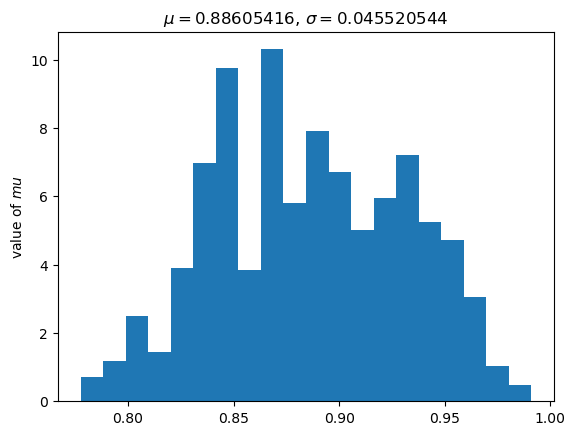

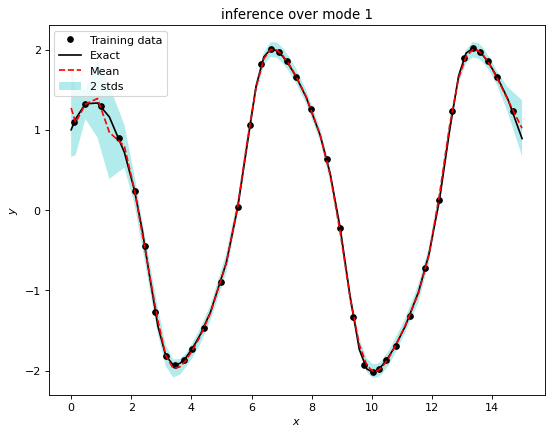

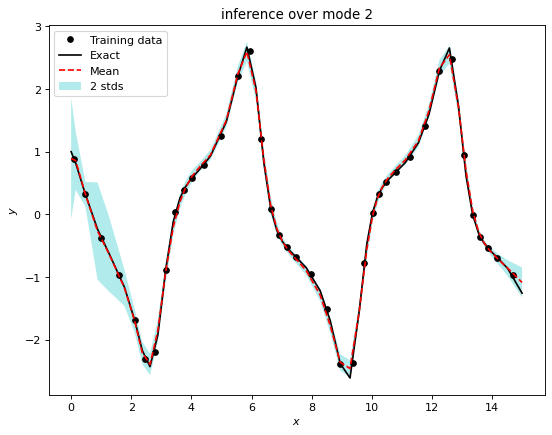

In [7]:
u_pred, r1_pred = model_S.predict(t_test, samples_S, processes_S, pde_fn=None)
plots(u_pred, t_test, u_test, t_u_train, u_train)

In [8]:
############################### Choose framework #################################
#processes, samples, model = Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers)

processes_D, samples_D, model_D = Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers)

Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...
Iteration:  0 , loss:  2.3530207
Iteration:  100 , loss:  1.8156847
Iteration:  200 , loss:  1.7446451
Iteration:  300 , loss:  1.6588471
Iteration:  400 , loss:  1.4240875
Iteration:  500 , loss:  0.9738922
Iteration:  600 , loss:  0.54840267
Iteration:  700 , loss:  0.34912965
Iteration:  800 , loss:  0.27545345
Iteration:  900 , loss:  0.23576573
Iteration:  1000 , loss:  0.1995645
Iteration:  1100 , loss:  0.16043837
Iteration:  1200 , loss:  0.12386259
Iteration:  1300 , loss:  0.09684688
Iteration:  1400 , loss:  0.07930424
Iteration:  1500 , loss:  0.066025175
Iteration:  1600 , loss:  0.05451741
Iteration:  1700 , loss:  0.04473283
Iteration:  1800 , loss:  0.036778387
Iteration:  1900 , loss:  0.030688014
Iteration:  2000 , loss:  0.025882186
Iteration:  2100 , loss:  0.021744303
Iteration:  2200 , loss:  0.020059241
Iteration:  2300 , loss:  0.015639227
Iteration:  

Iteration:  600 , loss:  0.405634
Iteration:  700 , loss:  0.22869332
Iteration:  800 , loss:  0.17452244
Iteration:  900 , loss:  0.13604455
Iteration:  1000 , loss:  0.104949005
Iteration:  1100 , loss:  0.08772012
Iteration:  1200 , loss:  0.07643012
Iteration:  1300 , loss:  0.066506
Iteration:  1400 , loss:  0.058025256
Iteration:  1500 , loss:  0.050833784
Iteration:  1600 , loss:  0.043997273
Iteration:  1700 , loss:  0.037944302
Iteration:  1800 , loss:  0.03257786
Iteration:  1900 , loss:  0.02810038
Iteration:  2000 , loss:  0.02737162
Iteration:  2100 , loss:  0.021065447
Iteration:  2200 , loss:  0.018159416
Iteration:  2300 , loss:  0.01662271
Iteration:  2400 , loss:  0.014660213
Iteration:  2500 , loss:  0.014999905
Iteration:  2600 , loss:  0.011792903
Iteration:  2700 , loss:  0.010518046
Iteration:  2800 , loss:  0.01079967
Iteration:  2900 , loss:  0.010804421
Iteration:  3000 , loss:  0.008069152
Iteration:  3100 , loss:  0.0076134023
Iteration:  3200 , loss:  0.007

Iteration:  1400 , loss:  0.067995876
Iteration:  1500 , loss:  0.057059538
Iteration:  1600 , loss:  0.050201662
Iteration:  1700 , loss:  0.038544856
Iteration:  1800 , loss:  0.031254686
Iteration:  1900 , loss:  0.03765797
Iteration:  2000 , loss:  0.020327896
Iteration:  2100 , loss:  0.016724927
Iteration:  2200 , loss:  0.014297441
Iteration:  2300 , loss:  0.011910092
Iteration:  2400 , loss:  0.010406964
Iteration:  2500 , loss:  0.009147059
Iteration:  2600 , loss:  0.00798695
Iteration:  2700 , loss:  0.0075276666
Iteration:  2800 , loss:  0.007402411
Iteration:  2900 , loss:  0.0060340916
Iteration:  3000 , loss:  0.005896692
Iteration:  3100 , loss:  0.005320372
Iteration:  3200 , loss:  0.0048239846
Iteration:  3300 , loss:  0.004577904
Iteration:  3400 , loss:  0.004985885
Iteration:  3500 , loss:  0.0044210167
Iteration:  3600 , loss:  0.0044084983
Iteration:  3700 , loss:  0.0040656035
Iteration:  3800 , loss:  0.0036093318
Iteration:  3900 , loss:  0.0034915924
Iterat

Iteration:  2200 , loss:  0.030207444
Iteration:  2300 , loss:  0.019532515
Iteration:  2400 , loss:  0.017343298
Iteration:  2500 , loss:  0.020550251
Iteration:  2600 , loss:  0.018306479
Iteration:  2700 , loss:  0.0132475
Iteration:  2800 , loss:  0.011426169
Iteration:  2900 , loss:  0.010241141
Iteration:  3000 , loss:  0.010483304
Iteration:  3100 , loss:  0.010412933
Iteration:  3200 , loss:  0.009699747
Iteration:  3300 , loss:  0.008268589
Iteration:  3400 , loss:  0.0128246965
Iteration:  3500 , loss:  0.012149606
Iteration:  3600 , loss:  0.00512751
Iteration:  3700 , loss:  0.0048885182
Iteration:  3800 , loss:  0.005238252
Iteration:  3900 , loss:  0.0064602476
Iteration:  4000 , loss:  0.00411682
Iteration:  4100 , loss:  0.006467331
Iteration:  4200 , loss:  0.005017785
Iteration:  4300 , loss:  0.0026395803
Iteration:  4400 , loss:  0.0025989495
Iteration:  4500 , loss:  0.0025179805
Iteration:  4600 , loss:  0.0022915888
Iteration:  4700 , loss:  0.001955773
Iteration

Iteration:  3100 , loss:  0.02805674
Iteration:  3200 , loss:  0.02642743
Iteration:  3300 , loss:  0.053372506
Iteration:  3400 , loss:  0.023291081
Iteration:  3500 , loss:  0.024052437
Iteration:  3600 , loss:  0.02068164
Iteration:  3700 , loss:  0.02009985
Iteration:  3800 , loss:  0.018422386
Iteration:  3900 , loss:  0.018729726
Iteration:  4000 , loss:  0.016475054
Iteration:  4100 , loss:  0.015470766
Iteration:  4200 , loss:  0.014748579
Iteration:  4300 , loss:  0.0137091875
Iteration:  4400 , loss:  0.013182019
Iteration:  4500 , loss:  0.012024693
Iteration:  4600 , loss:  0.012759757
Iteration:  4700 , loss:  0.010385658
Iteration:  4800 , loss:  0.014168833
Iteration:  4900 , loss:  0.008905351
Iteration:  5000 , loss:  0.029325973
Iteration:  5100 , loss:  0.0075927065
Iteration:  5200 , loss:  0.0069384943
Iteration:  5300 , loss:  0.0064354395
Iteration:  5400 , loss:  0.0058422135
Iteration:  5500 , loss:  0.0053932182
Iteration:  5600 , loss:  0.0048669144
Iteration

Iteration:  4100 , loss:  0.0020033342
Iteration:  4200 , loss:  0.0021825556
Iteration:  4300 , loss:  0.0016613589
Iteration:  4400 , loss:  0.001578733
Iteration:  4500 , loss:  0.0029894628
Iteration:  4600 , loss:  0.0019379098
Iteration:  4700 , loss:  0.001785546
Iteration:  4800 , loss:  0.0019646788
Iteration:  4900 , loss:  0.0025967835
Iteration:  5000 , loss:  0.0016158718
Iteration:  5100 , loss:  0.001306891
Iteration:  5200 , loss:  0.0019185696
Iteration:  5300 , loss:  0.0013114761
Iteration:  5400 , loss:  0.002422637
Iteration:  5500 , loss:  0.0010191585
Iteration:  5600 , loss:  0.0024481665
Iteration:  5700 , loss:  0.0016019339
Iteration:  5800 , loss:  0.000914296
Iteration:  5900 , loss:  0.0015154537
Iteration:  6000 , loss:  0.0025154904
Iteration:  6100 , loss:  0.0006547071
Iteration:  6200 , loss:  0.0010980106
Iteration:  6300 , loss:  0.00067774055
Iteration:  6400 , loss:  0.0006921351
Iteration:  6500 , loss:  0.0007438058
Iteration:  6600 , loss:  0.0

Iteration:  4900 , loss:  0.0033475275
Iteration:  5000 , loss:  0.0043702703
Iteration:  5100 , loss:  0.0055518285
Iteration:  5200 , loss:  0.003562363
Iteration:  5300 , loss:  0.007702942
Iteration:  5400 , loss:  0.0022427838
Iteration:  5500 , loss:  0.002704588
Iteration:  5600 , loss:  0.0026522966
Iteration:  5700 , loss:  0.0020689606
Iteration:  5800 , loss:  0.002078156
Iteration:  5900 , loss:  0.00313814
Iteration:  6000 , loss:  0.0017285189
Iteration:  6100 , loss:  0.0021313848
Iteration:  6200 , loss:  0.0018298894
Iteration:  6300 , loss:  0.0033769747
Iteration:  6400 , loss:  0.0018435364
Iteration:  6500 , loss:  0.0015112334
Iteration:  6600 , loss:  0.0025164837
Iteration:  6700 , loss:  0.0037057935
Iteration:  6800 , loss:  0.0014642515
Iteration:  6900 , loss:  0.0012937261
Iteration:  7000 , loss:  0.0029542586
Iteration:  7100 , loss:  0.0016101667
Iteration:  7200 , loss:  0.0021558534
Iteration:  7300 , loss:  0.0032651697
Iteration:  7400 , loss:  0.001

Iteration:  5700 , loss:  0.001016074
Iteration:  5800 , loss:  0.0014096898
Iteration:  5900 , loss:  0.0009477592
Iteration:  6000 , loss:  0.0021056337
Iteration:  6100 , loss:  0.0012721026
Iteration:  6200 , loss:  0.0010717153
Iteration:  6300 , loss:  0.001226032
Iteration:  6400 , loss:  0.0009642814
Iteration:  6500 , loss:  0.001951457
Iteration:  6600 , loss:  0.0008417601
Iteration:  6700 , loss:  0.00069345155
Iteration:  6800 , loss:  0.000747743
Iteration:  6900 , loss:  0.0011406564
Iteration:  7000 , loss:  0.00079877954
Iteration:  7100 , loss:  0.00061643956
Iteration:  7200 , loss:  0.0008176375
Iteration:  7300 , loss:  0.0006664393
Iteration:  7400 , loss:  0.0006913599
Iteration:  7500 , loss:  0.0006053124
Iteration:  7600 , loss:  0.0012584839
Iteration:  7700 , loss:  0.0028094894
Iteration:  7800 , loss:  0.0013883028
Iteration:  7900 , loss:  0.001223219
Iteration:  8000 , loss:  0.0010307145
Iteration:  8100 , loss:  0.003889814
Iteration:  8200 , loss:  0.

Iteration:  6400 , loss:  0.0007117409
Iteration:  6500 , loss:  0.0010039852
Iteration:  6600 , loss:  0.00058305816
Iteration:  6700 , loss:  0.0011120687
Iteration:  6800 , loss:  0.00095631863
Iteration:  6900 , loss:  0.0005116598
Iteration:  7000 , loss:  0.000869801
Iteration:  7100 , loss:  0.0006947896
Iteration:  7200 , loss:  0.0013496433
Iteration:  7300 , loss:  0.0009965975
Iteration:  7400 , loss:  0.00061835087
Iteration:  7500 , loss:  0.0014890251
Iteration:  7600 , loss:  0.0012738348
Iteration:  7700 , loss:  0.0011205464
Iteration:  7800 , loss:  0.0013530743
Iteration:  7900 , loss:  0.0004704961
Iteration:  8000 , loss:  0.0004388963
Iteration:  8100 , loss:  0.0005120415
Iteration:  8200 , loss:  0.00042613657
Iteration:  8300 , loss:  0.0005006912
Iteration:  8400 , loss:  0.0004946069
Iteration:  8500 , loss:  0.0021393155
Iteration:  8600 , loss:  0.0010539562
Iteration:  8700 , loss:  0.00045955426
Iteration:  8800 , loss:  0.0016221813
Iteration:  8900 , lo

Iteration:  7200 , loss:  0.0009943346
Iteration:  7300 , loss:  0.00087601796
Iteration:  7400 , loss:  0.0026284556
Iteration:  7500 , loss:  0.0007238483
Iteration:  7600 , loss:  0.0013169664
Iteration:  7700 , loss:  0.0010670312
Iteration:  7800 , loss:  0.00064526696
Iteration:  7900 , loss:  0.0023032213
Iteration:  8000 , loss:  0.00078049855
Iteration:  8100 , loss:  0.0015418316
Iteration:  8200 , loss:  0.0015474114
Iteration:  8300 , loss:  0.0006379888
Iteration:  8400 , loss:  0.0018014654
Iteration:  8500 , loss:  0.0010099561
Iteration:  8600 , loss:  0.00093744067
Iteration:  8700 , loss:  0.0010555387
Iteration:  8800 , loss:  0.0005754591
Iteration:  8900 , loss:  0.001782286
Iteration:  9000 , loss:  0.00066455716
Iteration:  9100 , loss:  0.0007530075
Iteration:  9200 , loss:  0.0015103564
Iteration:  9300 , loss:  0.0007770269
Iteration:  9400 , loss:  0.0005921411
Iteration:  9500 , loss:  0.0010076631
Iteration:  9600 , loss:  0.0006245644
Iteration:  9700 , lo

Iteration:  8100 , loss:  0.001867807
Iteration:  8200 , loss:  0.0019452125
Iteration:  8300 , loss:  0.0014295061
Iteration:  8400 , loss:  0.001519731
Iteration:  8500 , loss:  0.0024802852
Iteration:  8600 , loss:  0.0010296571
Iteration:  8700 , loss:  0.0024418423
Iteration:  8800 , loss:  0.000981365
Iteration:  8900 , loss:  0.0009757256
Iteration:  9000 , loss:  0.00095272076
Iteration:  9100 , loss:  0.0009726671
Iteration:  9200 , loss:  0.00078877865
Iteration:  9300 , loss:  0.0009047056
Iteration:  9400 , loss:  0.0016166995
Iteration:  9500 , loss:  0.00070877164
Iteration:  9600 , loss:  0.0018634486
Iteration:  9700 , loss:  0.001067209
Iteration:  9800 , loss:  0.0008397492
Iteration:  9900 , loss:  0.0019169402
Iteration:  10000 , loss:  0.0012936085
Iteration:  10100 , loss:  0.00061029696
Iteration:  10200 , loss:  0.0012548859
Iteration:  10300 , loss:  0.00066191016
Iteration:  10400 , loss:  0.0012469181
Iteration:  10500 , loss:  0.0012264597
Iteration:  10600 

Iteration:  9000 , loss:  0.000687401
Iteration:  9100 , loss:  0.0011773325
Iteration:  9200 , loss:  0.0015470313
Iteration:  9300 , loss:  0.0028670097
Iteration:  9400 , loss:  0.0011997096
Iteration:  9500 , loss:  0.002807935
Iteration:  9600 , loss:  0.0018148853
Iteration:  9700 , loss:  0.00053324585
Iteration:  9800 , loss:  0.0006299567
Iteration:  9900 , loss:  0.0025849089
Iteration:  10000 , loss:  0.0014319367
Iteration:  10100 , loss:  0.0006073042
Iteration:  10200 , loss:  0.0005063584
Iteration:  10300 , loss:  0.0005239914
Iteration:  10400 , loss:  0.0032066908
Iteration:  10500 , loss:  0.0004404967
Iteration:  10600 , loss:  0.0017193772
Iteration:  10700 , loss:  0.00078734505
Iteration:  10800 , loss:  0.0027362695
Iteration:  10900 , loss:  0.0004640055
Iteration:  11000 , loss:  0.0019147489
Iteration:  11100 , loss:  0.0011614216
Iteration:  11200 , loss:  0.0005206268
Iteration:  11300 , loss:  0.0011733316
Iteration:  11400 , loss:  0.00040142046
Iteration

Iteration:  9800 , loss:  0.00031819494
Iteration:  9900 , loss:  0.0007032007
Iteration:  10000 , loss:  0.00035118367
Iteration:  10100 , loss:  0.00040170088
Iteration:  10200 , loss:  0.0004146302
Iteration:  10300 , loss:  0.00041930642
Iteration:  10400 , loss:  0.00069184013
Iteration:  10500 , loss:  0.00062970794
Iteration:  10600 , loss:  0.0003172348
Iteration:  10700 , loss:  0.00027567375
Iteration:  10800 , loss:  0.0005627472
Iteration:  10900 , loss:  0.0012192208
Iteration:  11000 , loss:  0.0003851461
Iteration:  11100 , loss:  0.00032640804
Iteration:  11200 , loss:  0.00053751556
Iteration:  11300 , loss:  0.0002790879
Iteration:  11400 , loss:  0.0005684893
Iteration:  11500 , loss:  0.0004551678
Iteration:  11600 , loss:  0.0019553334
Iteration:  11700 , loss:  0.00054595375
Iteration:  11800 , loss:  0.00080731866
Iteration:  11900 , loss:  0.00037799845
Iteration:  12000 , loss:  0.0007759303
Iteration:  12100 , loss:  0.00026805562
Iteration:  12200 , loss:  0.

Iteration:  10500 , loss:  0.0006667347
Iteration:  10600 , loss:  0.0004389858
Iteration:  10700 , loss:  0.0017241436
Iteration:  10800 , loss:  0.0007403087
Iteration:  10900 , loss:  0.0009553523
Iteration:  11000 , loss:  0.00042815565
Iteration:  11100 , loss:  0.0004269434
Iteration:  11200 , loss:  0.0005668761
Iteration:  11300 , loss:  0.00040520923
Iteration:  11400 , loss:  0.0006852791
Iteration:  11500 , loss:  0.00050511997
Iteration:  11600 , loss:  0.00092551886
Iteration:  11700 , loss:  0.0006988433
Iteration:  11800 , loss:  0.0022957833
Iteration:  11900 , loss:  0.0007266675
Iteration:  12000 , loss:  0.00058546854
Iteration:  12100 , loss:  0.00039092335
Iteration:  12200 , loss:  0.0007955415
Iteration:  12300 , loss:  0.0003829184
Iteration:  12400 , loss:  0.00034618066
Iteration:  12500 , loss:  0.00034379697
Iteration:  12600 , loss:  0.00055369537
Iteration:  12700 , loss:  0.00034421223
Iteration:  12800 , loss:  0.00033366468
Iteration:  12900 , loss:  0.

Iteration:  11400 , loss:  0.0018155942
Iteration:  11500 , loss:  0.0009190563
Iteration:  11600 , loss:  0.0003130608
Iteration:  11700 , loss:  0.0014396085
Iteration:  11800 , loss:  0.0005910981
Iteration:  11900 , loss:  0.0011569071
Iteration:  12000 , loss:  0.0011361247
Iteration:  12100 , loss:  0.00040093914
Iteration:  12200 , loss:  0.00062087656
Iteration:  12300 , loss:  0.0009076544
Iteration:  12400 , loss:  0.0007935333
Iteration:  12500 , loss:  0.0011229387
Iteration:  12600 , loss:  0.0003584255
Iteration:  12700 , loss:  0.00035040887
Iteration:  12800 , loss:  0.0023477254
Iteration:  12900 , loss:  0.00027502427
Iteration:  13000 , loss:  0.00046508067
Iteration:  13100 , loss:  0.00031191425
Iteration:  13200 , loss:  0.0004570487
Iteration:  13300 , loss:  0.00050259737
Iteration:  13400 , loss:  0.00032051417
Iteration:  13500 , loss:  0.0007425512
Iteration:  13600 , loss:  0.0011918554
Iteration:  13700 , loss:  0.00030233923
Iteration:  13800 , loss:  0.00

Iteration:  12200 , loss:  0.0011770783
Iteration:  12300 , loss:  0.0016838579
Iteration:  12400 , loss:  0.0006498491
Iteration:  12500 , loss:  0.0010496223
Iteration:  12600 , loss:  0.0015225456
Iteration:  12700 , loss:  0.0012352117
Iteration:  12800 , loss:  0.0006556538
Iteration:  12900 , loss:  0.0005409159
Iteration:  13000 , loss:  0.00052199926
Iteration:  13100 , loss:  0.00032381163
Iteration:  13200 , loss:  0.00044396787
Iteration:  13300 , loss:  0.00053789816
Iteration:  13400 , loss:  0.00082926947
Iteration:  13500 , loss:  0.0008686639
Iteration:  13600 , loss:  0.00055748963
Iteration:  13700 , loss:  0.0008995243
Iteration:  13800 , loss:  0.0008386948
Iteration:  13900 , loss:  0.0010472563
Iteration:  14000 , loss:  0.0008314627
Iteration:  14100 , loss:  0.001289906
Iteration:  14200 , loss:  0.00033470508
Iteration:  14300 , loss:  0.0012069228
Iteration:  14400 , loss:  0.00034031557
Iteration:  14500 , loss:  0.00080411
Iteration:  14600 , loss:  0.000638

Iteration:  13100 , loss:  0.0008110799
Iteration:  13200 , loss:  0.00040781757
Iteration:  13300 , loss:  0.0028430796
Iteration:  13400 , loss:  0.0004631407
Iteration:  13500 , loss:  0.00037582903
Iteration:  13600 , loss:  0.0003737194
Iteration:  13700 , loss:  0.00037385372
Iteration:  13800 , loss:  0.0004969895
Iteration:  13900 , loss:  0.0009807915
Iteration:  14000 , loss:  0.00066960417
Iteration:  14100 , loss:  0.0008768227
Iteration:  14200 , loss:  0.0003681308
Iteration:  14300 , loss:  0.0005610835
Iteration:  14400 , loss:  0.0003851747
Iteration:  14500 , loss:  0.0006161424
Iteration:  14600 , loss:  0.0005904719
Iteration:  14700 , loss:  0.0005280952
Iteration:  14800 , loss:  0.0003362299
Iteration:  14900 , loss:  0.00037022255
Iteration:  15000 , loss:  0.0005302884
Iteration:  15100 , loss:  0.00034112472
Iteration:  15200 , loss:  0.0012580496
Iteration:  15300 , loss:  0.0007793129
Iteration:  15400 , loss:  0.0010233007
Iteration:  15500 , loss:  0.00083

Iteration:  13900 , loss:  0.0007425653
Iteration:  14000 , loss:  0.00094859186
Iteration:  14100 , loss:  0.0016429964
Iteration:  14200 , loss:  0.00046807624
Iteration:  14300 , loss:  0.0006865868
Iteration:  14400 , loss:  0.0012724258
Iteration:  14500 , loss:  0.0004020931
Iteration:  14600 , loss:  0.0003245634
Iteration:  14700 , loss:  0.00068638544
Iteration:  14800 , loss:  0.0005124378
Iteration:  14900 , loss:  0.0003841934
Iteration:  15000 , loss:  0.0005962162
Iteration:  15100 , loss:  0.0012978006
Iteration:  15200 , loss:  0.0014455436
Iteration:  15300 , loss:  0.00031751228
Iteration:  15400 , loss:  0.00090501853
Iteration:  15500 , loss:  0.00032093364
Iteration:  15600 , loss:  0.002219256
Iteration:  15700 , loss:  0.00029594323
Iteration:  15800 , loss:  0.00040519342
Iteration:  15900 , loss:  0.00055878266
Iteration:  16000 , loss:  0.000357937
Iteration:  16100 , loss:  0.0009856229
Iteration:  16200 , loss:  0.0005319633
Iteration:  16300 , loss:  0.0003

Iteration:  14700 , loss:  0.00037677735
Iteration:  14800 , loss:  0.0020739622
Iteration:  14900 , loss:  0.00022225923
Iteration:  15000 , loss:  0.0004645972
Iteration:  15100 , loss:  0.0002244776
Iteration:  15200 , loss:  0.0002823699
Iteration:  15300 , loss:  0.00052134605
Iteration:  15400 , loss:  0.00032297277
Iteration:  15500 , loss:  0.00067815994
Iteration:  15600 , loss:  0.0013361825
Iteration:  15700 , loss:  0.0010248147
Iteration:  15800 , loss:  0.00032587166
Iteration:  15900 , loss:  0.00082325144
Iteration:  16000 , loss:  0.00035808067
Iteration:  16100 , loss:  0.00022723581
Iteration:  16200 , loss:  0.00023005984
Iteration:  16300 , loss:  0.0014681022
Iteration:  16400 , loss:  0.0004198465
Iteration:  16500 , loss:  0.0002930246
Iteration:  16600 , loss:  0.00032353133
Iteration:  16700 , loss:  0.0011552555
Iteration:  16800 , loss:  0.00040036085
Iteration:  16900 , loss:  0.0004107787
Iteration:  17000 , loss:  0.0006649666
Iteration:  17100 , loss:  0

Iteration:  15500 , loss:  0.0006187709
Iteration:  15600 , loss:  0.0007675595
Iteration:  15700 , loss:  0.00039017558
Iteration:  15800 , loss:  0.0007894194
Iteration:  15900 , loss:  0.0007213636
Iteration:  16000 , loss:  0.0009185083
Iteration:  16100 , loss:  0.0007863135
Iteration:  16200 , loss:  0.00024039339
Iteration:  16300 , loss:  0.0006183489
Iteration:  16400 , loss:  0.00035907706
Iteration:  16500 , loss:  0.00043692254
Iteration:  16600 , loss:  0.00052895746
Iteration:  16700 , loss:  0.00039978445
Iteration:  16800 , loss:  0.00025558285
Iteration:  16900 , loss:  0.00078505586
Iteration:  17000 , loss:  0.0003420388
Iteration:  17100 , loss:  0.00086354185
Iteration:  17200 , loss:  0.0003989776
Iteration:  17300 , loss:  0.00034316216
Iteration:  17400 , loss:  0.0003307976
Iteration:  17500 , loss:  0.00047369782
Iteration:  17600 , loss:  0.00036828662
Iteration:  17700 , loss:  0.00036791948
Iteration:  17800 , loss:  0.0006770918
Iteration:  17900 , loss:  

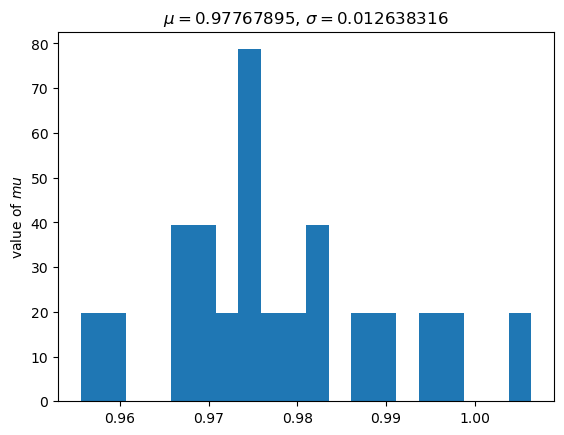

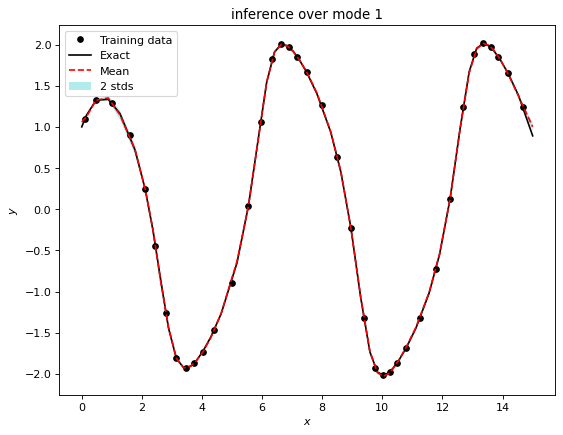

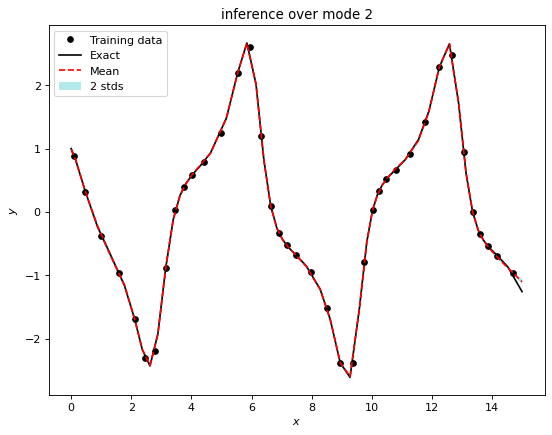

In [9]:
u_pred, r1_pred = model_D.predict(t_test, samples_D, processes_D, pde_fn=None)
plots(u_pred, t_test, u_test, t_u_train, u_train)